In [1]:
import pandas as pd

df = pd.read_csv('data/seniority-level.csv')

In [2]:
df.dropna(axis=0, inplace=True)

In [3]:
df.head()

,jobtitle,link,summary,description,Seniority
0,Einkäufer (w/m/d),https://www.roberthalf.de/job/munchen/einkaufe...,Einkäufer (w/m/d) gesucht - Für unseren Kunden...,"<div class=""rh-job-page__job-info-text""><p><st...",Medior
1,Bilanzbuchhalter (w/m/d),https://www.roberthalf.de/job/essen/bilanzbuch...,Bilanzbuchhalter (w/m/d) gesucht - Für unseren...,"<div class=""rh-job-page__job-info-text""><p><st...",Senior
2,Bilanzbuchhalter (w/m/d),https://www.roberthalf.de/job/duisburg/bilanzb...,Bilanzbuchhalter (w/m/d) gesucht - Für unseren...,"<div class=""rh-job-page__job-info-text""><p><st...",Senior
3,Finanzbuchhalter (w/m/d),https://www.roberthalf.de/job/unna/finanzbuchh...,Finanzbuchhalter (w/m/d) gesucht - Für unseren...,"<div class=""rh-job-page__job-info-text""><p><st...",Medior
4,Sachbearbeiter Logistik (w/m/d),https://www.roberthalf.de/job/worms/sachbearbe...,Sachbearbeiter Logistik (w/m/d) gesucht - Für ...,"<div class=""rh-job-page__job-info-text""><p><st...",Junior


In [4]:
df.shape

(140, 5)

In [24]:
df_jf = pd.read_csv('data/seniority-level-jf.csv')

In [25]:
df_jf.dropna(axis=0, inplace=True)

In [26]:
df_jf.head()

,vac_title,fulltext,Seniority
0,Praktikant IT-Entwicklung - Projekt Industrie ...,Praktikant IT-Entwicklung - Projekt Industrie ...,Junior
1,Assistenzärzte (m/w) für ein Ausbildungscurric...,assistenzärzte (m/w) für ein ausbildungscurric...,Medior
2,Koch (m/w),Das Sylter Stadtgeflüster ist eine Genussoase ...,Medior
3,"Fachinformatiker/in, Systemintegration","Fachinformatiker/in, Systemintegration ?% Eign...",Junior
4,Praktikum im Spezialtiefbau - Bauingenieurwesen,Praktikum im Spezialtiefbau - Bauingenieurwese...,Junior


In [27]:
df_jf.shape

(219, 3)

In [17]:
df_jf['fulltext'][3]

'Fachinformatiker/in, Systemintegration ?% Eignung für diesen Ausbildungsplatz Eignungs-Check JETZT BEWERBEN! __________________________________________________ Die Pärchen Software und Hardware, Informationstechnologie und Telekommunikation, Betriebssysteme und Netzwerke sind Dir nicht fremd? Dann bist Du hier genau richtig! Dich begeistert die ganze Palette der Informations- und Telekommunikationstechnologie? Du verstehst, wie komplexe Systeme funktionieren und wie Hard- und Softwarekomponenten integriert werden? Dann solltest Du die Ausbildung zum/r "Fachinformatiker/in Systemintegration" bei uns machen Die Ausbildung beginnt am 1. September und dauert drei Jahre (Verkürzung möglich). Für die Dauer der Ausbildung stellt die Telekom Dir einen Laptop und mobiles Internet zur Verfügung. Anforderungen Schulnoten sind nicht alles was zählt. Wir sind der Meinung, dass Du uns am besten mit Deinem Talent, Deinem Engagement und Deiner Persönlichkeit überzeugen kannst. Deswegen bist Du bei un

In [28]:
from gensim.parsing.preprocessing import preprocess_string, RE_TAGS, strip_punctuation, stem_text, \
    strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short, strip_non_alphanum
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from nltk.stem.snowball import GermanStemmer
from unicodedata import normalize

STOPWORDS = {    
    'such', 'suchen', 'da', 'ist', 'mit', 'de', 'und', 'mit', 'per', 'uber', 'unser',
    'com', 'der', 'den', 'auf', 'sie', 'directhir', 'ihr', 'vom',  'wir', 'bei', 'sind',
    'freuen', 'ihnen', 'jetzt', 'ein', 'dem', 'von', 'fur', 'aber', 'diesem', 'au',
    'sein', 'als', 'einen', 'hat', 'dein', 'dich', 'die', 'dies', 'bi', 'etc', 'bitt',
    'di', 'dann', 'bzw', 'dir', 'un', 'bewirb', 'beim', 'zum', 'bist', 'dass', 'zur',
    'deinen', 'seit', 'also', 'bietet', 'bieten', 'oder', 'bis', 'uns', 'auch', 'des',
    'referenznummer', 
    
    'frau', 'herr', 'anna', 'alexandra', 'christian', 'atak', 'katharina', 'schneid',
    'martin', 'hausen', 'robert', 'half',
    
    'and', 'for', 'onlin', 'career', 'level', 'search', 'alert', 'code', 'creat', 'apply',
    'bad', 'area', 'amp', 'are',
    
    'großraum', 'groraum', 'raum', 'regio', 'sitz', 'munchen', 'essen', 'koln', 'berlin',
    'bayern', 'bremen', 'stuttgart', 'munch', 'schaumburg',
    
    '60050', '2017', '2018', '2019', '10000', '60030', '089', '06640', '06780', '06600',
}

def my_remove_tags(s):
    return RE_TAGS.sub(" ", s)

def my_remove_accents(s):
    return normalize('NFKD', s).encode('ASCII', 'ignore')

def my_strip_stopwords(s):
    return ' '.join(x for x in s.split() if x not in STOPWORDS)

stemmer = GermanStemmer()

def nltk_stem(s):
    return ' '.join([stemmer.stem(x) for x in s.split()])


my_filters = [
    lambda x: x.lower(), my_remove_tags, my_remove_accents, strip_punctuation, strip_non_alphanum,
    strip_multiple_whitespaces, strip_short, my_strip_stopwords, nltk_stem
]

def my_tokenizer(s):
    return preprocess_string(s, filters=my_filters)
    
vect = CountVectorizer(min_df=5, max_df=0.2, analyzer='word', tokenizer=my_tokenizer, ngram_range=(1,2),
                       stop_words=STOPWORDS)

le = LabelEncoder()

X = vect.fit_transform(df['description'].tolist() + df_jf['fulltext'].tolist())
y = le.fit_transform(df['Seniority'].tolist() + df_jf['Seniority'].tolist())

scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X)

svd = TruncatedSVD(n_components=250)
X_lsa = svd.fit_transform(X)

In [30]:
#vect.stop_words_

#{x:y for x,y in vect.vocabulary_.items() if y > 5}

In [29]:
X.shape

(359, 1852)

In [30]:
X_lsa.shape

(359, 250)

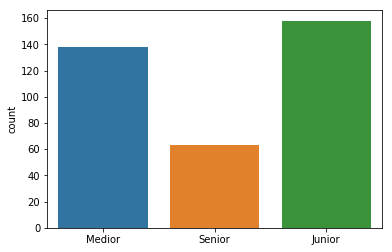

In [31]:
import seaborn as sns
%matplotlib inline

ax = sns.countplot(x=(df['Seniority'].tolist() + df_jf['Seniority'].tolist()))

In [34]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC

classifiers = [
    MultinomialNB(),
    LogisticRegression(solver='lbfgs', multi_class='multinomial'),
    LogisticRegression(solver='lbfgs', multi_class='multinomial', class_weight='balanced'),
    #LinearSVC(),
    SVC(kernel='linear', probability=True),
    #KNeighborsClassifier(),
    RandomForestClassifier(n_estimators=25, min_samples_split=10)
]

for clf in classifiers:
    accs = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='accuracy')
    f1s = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='f1_macro')
    lls = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='neg_log_loss')

    print("{:>24} Accuracy: {:.2f} (+/- {:.2f}) F1: {:.2f} (+/- {:.2f}) Log loss: {:.2f} (+/- {:.2f})" \
          .format(clf.__class__.__name__, accs.mean(), accs.std(), f1s.mean(), f1s.std(), lls.mean(), lls.std()))

           MultinomialNB Accuracy: 0.56 (+/- 0.07) F1: 0.54 (+/- 0.04) Log loss: -4.82 (+/- 0.98)
      LogisticRegression Accuracy: 0.59 (+/- 0.05) F1: 0.56 (+/- 0.07) Log loss: -1.15 (+/- 0.19)
      LogisticRegression Accuracy: 0.61 (+/- 0.02) F1: 0.56 (+/- 0.04) Log loss: -1.10 (+/- 0.19)
                     SVC Accuracy: 0.53 (+/- 0.03) F1: 0.53 (+/- 0.06) Log loss: -0.91 (+/- 0.07)
  RandomForestClassifier Accuracy: 0.55 (+/- 0.06) F1: 0.46 (+/- 0.08) Log loss: -0.88 (+/- 0.05)


In [35]:
##
## Compare classifiers again, using LSA transformed input
##

classifiers = [
    LogisticRegression(solver='lbfgs', multi_class='multinomial'),
    LogisticRegression(solver='lbfgs', multi_class='multinomial', class_weight='balanced'),
    SVC(kernel='linear', probability=True),
]

for clf in classifiers:
    accs = cross_val_score(clf, X_lsa, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='accuracy')
    f1s = cross_val_score(clf, X_lsa, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='f1_macro')
    lls = cross_val_score(clf, X_lsa, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='neg_log_loss')

    print("{:>24} Accuracy: {:.2f} (+/- {:.2f}) F1: {:.2f} (+/- {:.2f}) Log loss: {:.2f} (+/- {:.2f})" \
          .format(clf.__class__.__name__, accs.mean(), accs.std(), f1s.mean(), f1s.std(), lls.mean(), lls.std()))

      LogisticRegression Accuracy: 0.57 (+/- 0.04) F1: 0.52 (+/- 0.03) Log loss: -1.43 (+/- 0.19)
      LogisticRegression Accuracy: 0.53 (+/- 0.06) F1: 0.50 (+/- 0.04) Log loss: -1.48 (+/- 0.18)
                     SVC Accuracy: 0.49 (+/- 0.07) F1: 0.46 (+/- 0.05) Log loss: -0.96 (+/- 0.02)


In [100]:
from sklearn.model_selection import train_test_split

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y)

#clf = MultinomialNB()
clf = LogisticRegression(solver='lbfgs', multi_class='multinomial', class_weight='balanced')
#clf = LinearSVC()
clf.fit(Xtr, ytr)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [36]:
Xtr.shape

(256, 1653)

In [37]:
Xte.shape

(64, 1653)

In [101]:
from sklearn.metrics import classification_report

ypred = clf.predict(Xte)

print(classification_report(yte, ypred, target_names=le.classes_))

              precision    recall  f1-score   support

      Junior       0.69      0.76      0.72        29
      Medior       0.68      0.62      0.65        24
      Senior       0.60      0.55      0.57        11

   micro avg       0.67      0.67      0.67        64
   macro avg       0.66      0.64      0.65        64
weighted avg       0.67      0.67      0.67        64



In [75]:
le.classes_

array(['Junior', 'Medior', 'Senior'], dtype='<U6')

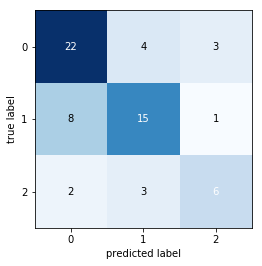

In [102]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(confusion_matrix(yte, ypred))

In [103]:
import numpy as np

feature_names = vect.get_feature_names()
for i, class_label in enumerate(le.classes_):
    top10 = np.argsort(clf.coef_[i])[-20:]
    print("%s: %s" % (class_label, ", ".join(feature_names[j] for j in top10)))
    print()

Junior: praktikum, erst erfahr, umfeld, schriftlich, rollout technik, kundenbetreu, fachinformat, ansprechpartn, gerat, elektron, speis, pfleg, student, support, recruiting, einarbeit, spa, junior, voraussetz, erst berufserfahr

Medior: haus, person betreu, renommiert, kundenberat, klein, web, client, lehr, produkt, stuttgart, nachstmog, administration, assistenz, wunschenswert, technisch, auendien, projekt, programm, mach, kreditorenbuchhalt

Senior: position, programmier, technik, kund unternehm, link, wunschenswert hab, softwar, firma, mehrjahr erfahr, anbind, develop, einschlag, zentrum, data, bau, reporting, art, mehr, mehrjahr, projektleit

